# Inference Attack with AutoML and MNIST Digits-- Trial \#2
ISU CEADS Lab under Dr. Leslie Kerby <br>
Samantha Ross <br><br>

This is a notebook detailing an inference attack (or "model stealing") against a target with an architecture utilizing EfficientNet. The attack uses AutoML (AutoKeras) and the MNIST Digits data set.

## TensorFlow Versioning
TensorFlow has now updated to v2.12. This notebook was originally created using TensorFlow v2.11. Given the simplicity of this data set, there was no need to save models in case of a notebook crash (from exceeding resources). If there are problems serializing the model, this is an internal TensorFlow error with certain EfficientNet models and the solution is to use "EfficientNetV2B0" instead of "EfficientNetB0."

# Imports

In [ ]:
# Installs and Imports
!pip install autokeras

import autokeras as ak
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Dataset Preparation 
Loading in, preprocessing, and creating a train-test-split of the MNIST Digits data

In [ ]:
# Dataset from TFDS
import tensorflow_datasets as tfds

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'mnist',
    split = ['train[:90%]', 'train[90%:]', 'test'], # 90% training set in ds_train and 10% in ds_valid
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)
ds_train

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Build transformation pipeline for TFDS Datasets 
def preprocess(image, label): 
  image = tf.image.resize(image, [32, 32]) # resize to 32x32 images
  return (image, label)

def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  return (image, label)

# apply data augmentation to training set only
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

# Victim Model
Model utilizing EfficientNetB0 with 32x32 rgb images <br>

In [ ]:
base_model = keras.applications.EfficientNetB0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(32,32,3)) # don't nec need 224x224 (needs at least 32x32)
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.02)(global_avg)
output = keras.layers.Dense(10, activation="softmax")(dropout)
victim_model2 = keras.models.Model(inputs=base_model.input, outputs=output)

16705208/16705208 [==============================] - 2s 0us/step


## Training
Using transfer learning

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

# Compile model
victim_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

# Train w/ frozen layers
history_vict = victim_model.fit(ds_train, 
                    epochs=15, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/15


1688/1688 [==============================] - ETA: 0s - loss: 1.0512 - accuracy: 0.6772

1688/1688 [==============================] - 51s 23ms/step - loss: 1.0512 - accuracy: 0.6772 - val_loss: 0.7233 - val_accuracy: 0.7790
Epoch 2/15
1688/1688 [==============================] - 32s 19ms/step - loss: 0.7061 - accuracy: 0.7772 - val_loss: 0.5848 - val_accuracy: 0.8195
Epoch 3/15
1688/1688 [==============================] - 27s 16ms/step - loss: 0.6149 - accuracy: 0.8056 - val_loss: 0.5233 - val_accuracy: 0.8343
Epoch 4/15
1688/1688 [==============================] - 33s 20ms/step - loss: 0.5661 - accuracy: 0.8181 - val_loss: 0.4794 - val_accuracy: 0.8500
Epoch 5/15
1688/1688 [==============================] - 28s 17ms/step - loss: 0.5346 - accuracy: 0.8281 - val_loss: 0.4515 - val_accuracy: 0.8548
Epoch 6/15
1688/1688 [==============================] - 26s 15ms/step - loss: 0.5112 - accuracy: 0.8346 - val_loss: 0.4312 - val_accuracy: 0.8643
Epoch 7/15
1688/1688 [==============================] - 27s 16ms/step - loss: 0.4942 - accuracy: 0.8400 - val_loss: 0.4149 - val_accura

In [ ]:
history_vict.model.evaluate(ds_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.3318 - accuracy: 0.9003


[0.3318145275115967, 0.9003000259399414]

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

# Compile model (resets model)
victim_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4),
                metrics=["accuracy"])

# Train w/ unfrozen layers
n_epochs = 20
history_vict_2 = victim_model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=2)])

# 9 min per epoch

Epoch 1/20


1688/1688 [==============================] - ETA: 0s - loss: 3.0705 - accuracy: 0.6580

1688/1688 [==============================] - 157s 82ms/step - loss: 3.0705 - accuracy: 0.6580 - val_loss: 0.5474 - val_accuracy: 0.8572
Epoch 2/20
1688/1688 [==============================] - 126s 75ms/step - loss: 0.5594 - accuracy: 0.8644 - val_loss: 0.2580 - val_accuracy: 0.9268
Epoch 3/20
1688/1688 [==============================] - 137s 81ms/step - loss: 0.2846 - accuracy: 0.9211 - val_loss: 0.1728 - val_accuracy: 0.9490
Epoch 4/20
1688/1688 [==============================] - 114s 68ms/step - loss: 0.1803 - accuracy: 0.9470 - val_loss: 0.1166 - val_accuracy: 0.9640
Epoch 5/20
1688/1688 [==============================] - 114s 67ms/step - loss: 0.1336 - accuracy: 0.9617 - val_loss: 0.1060 - val_accuracy: 0.9683
Epoch 6/20
1688/1688 [==============================] - 110s 65ms/step - loss: 0.0878 - accuracy: 0.9735 - val_loss: 0.1034 - val_accuracy: 0.9720
Epoch 7/20
1688/1688 [==============================] - 109s 65ms/step - loss: 0.0708 - accuracy: 0.9781 - val_loss: 0.0961 - val

In [ ]:
victim_model.evaluate(ds_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.0822 - accuracy: 0.9770


[0.08219792693853378, 0.9769999980926514]

## Predictions, Misclassifieds, and CM

In [ ]:
y_pred = np.argmax(victim_model.predict(ds_test), axis=-1)
print(y_pred[:10])

313/313 [==============================] - 34s 10ms/step
[2 0 4 8 7 6 0 6 3 1]


In [ ]:
# extract labels from ds_test 
# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset

y_test = np.concatenate([y for x, y in ds_test], axis=0)

# Compare first 20
print(y_pred[:20])
print(y_test[:20])

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0]
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0]


In [ ]:
# proof datasets ARE different (see last 2 numbers in each)
print(y_pred[80:100]) # victim model predictions
print(y_test[80:100]) # actual

[0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 1 6]
[0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 7 6]


In [ ]:
# Extract images from ds_test
t_ds = ds_test.unbatch()
X_test = np.asarray(list(t_ds.map(lambda x, y: x)))

In [ ]:
# Ensure correct data / format
X_test.shape

(10000, 32, 32, 1)

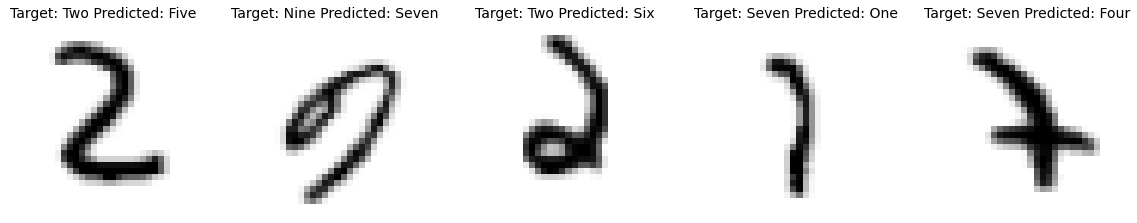

In [ ]:
# MUST EXTRACT X_TEST and Y_TEST FROM DS_TEST FIRST!!!

# Display misclassified images for this experimental model
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 
           'Six', 'Seven', 'Eight', 'Nine']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, y_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(32,32), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[y_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

In [ ]:
# Confusion Matrix showing victim model misclassifications

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# Model Stealing
Reverse engineering the target model by generating an attack model with AutoKeras

In [ ]:
# Use a subset of images from the original dataset (X_test) and the victim 
# model's predictions on that data (y_pred)

X_train_tr2, X_test2, y_train_tr2, y_test2 = train_test_split(X_test, y_pred,
                                                                test_size=3/10)
print(X_test.shape)
print(y_test2.shape)

print()
print(X_train_tr2.shape)
print(X_test2.shape)
print(y_train_tr2.shape)
print(y_test2.shape)

(10000, 32, 32, 1)
(3000,)

(7000, 32, 32, 1)
(3000, 32, 32, 1)
(7000,)
(3000,)


In [ ]:
# initialize AK image classifier that will try 2 models (for time)
auto_model = ak.ImageClassifier(max_trials=3, loss = 'sparse_categorical_crossentropy') # specifying loss

# AK defaults to binary_crossentropy or categorical_crossentropy depending on # of classes
# Changing (specifying) sparse_categorical for victim-->attack prediction data compatability

In [ ]:
# Search for the best model (out of 3)
am3_history = auto_model.fit(X_train_tr2, y_train_tr2, 20,
                 callbacks=[keras.callbacks.EarlyStopping(patience=2)]) #patience = 2 for time

Trial 3 Complete [00h 44m 39s]
val_loss: 0.1017850935459137

Best val_loss So Far: 0.1017850935459137
Total elapsed time: 00h 54m 40s


Epoch 1/20


Not enough memory, reduce batch size to 16.
Epoch 1/20
438/438 [==============================] - 420s 958ms/step - loss: 0.7361 - accuracy: 0.8147
Epoch 2/20
438/438 [==============================] - 421s 962ms/step - loss: 0.1685 - accuracy: 0.9549
Epoch 3/20
438/438 [==============================] - 420s 958ms/step - loss: 0.1111 - accuracy: 0.9690
Epoch 4/20
438/438 [==============================] - 423s 965ms/step - loss: 0.0725 - accuracy: 0.9804
Epoch 5/20
438/438 [==============================] - 422s 963ms/step - loss: 0.0485 - accuracy: 0.9866
Epoch 6/20
438/438 [==============================] - 423s 965ms/step - loss: 0.0371 - accuracy: 0.9910
Epoch 7/20
438/438 [==============================] - 422s 964ms/step - loss: 0.0241 - accuracy: 0.9940
Epoch 8/20
438/438 [==============================] - 421s 961ms/step - loss: 0.0157 - accuracy: 0.9964
Epoch 9/20
438/438 [==============================] - 421s 962ms/step - loss: 0.0135 - accuracy: 0.9971
Epoch 10/20
438/438 

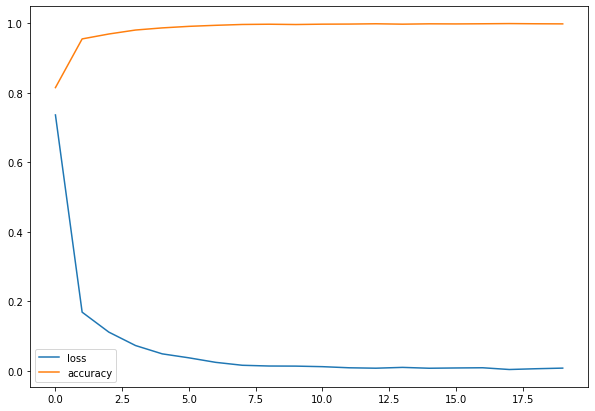

In [ ]:
# Graph
pd.DataFrame(am3_history.history).plot(figsize=(10,7)) 

In [ ]:
# Evaluate stolen model's accuracy on its own test set
auto_model.evaluate(X_test2, y_test2)

94/94 [==============================] - 38s 351ms/step - loss: 0.1564 - accuracy: 0.9697
[0.156419038772583, 0.9696666598320007]


## Export Best Model
Export best model

In [ ]:
stolen_model = auto_model.export_model()
stolen_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 cast_to_float32 (CastToFloat32  (None, 32, 32, 1)   0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 1)    3           ['cast_to_float32[0][0]']        
                                                                                                  
 random_translation (RandomTran  (None, 32, 32, 1)   0           ['normalization[0][0]']      

## Predictions, Missclassifieds and CM

In [ ]:
attack_pred = np.argmax(stolen_model.predict(X_test2), axis=-1)
print(attack_pred4[:20]) # attack model's predictions
print(y_test2[:20]) # attack model's labels (victim's predictions on X_test2)

94/94 [==============================] - 32s 344ms/step
[7 7 9 7 9 5 1 9 9 1 6 9 3 1 7 7 6 9 2 5]
[7 7 9 7 8 5 1 9 9 1 6 9 3 1 7 7 6 5 2 5]


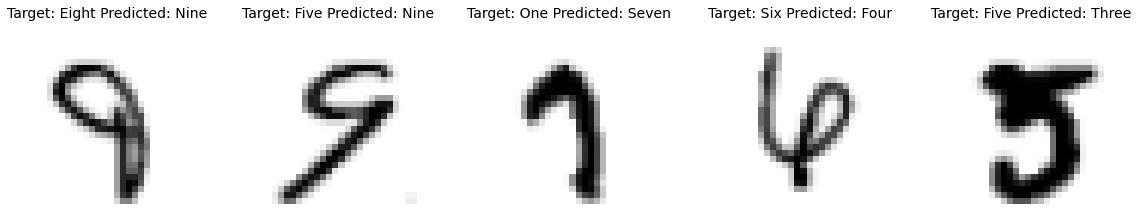

In [ ]:
# Display misclassified images for this experimental model
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 
           'Six', 'Seven', 'Eight', 'Nine']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test2, attack_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test2[misclassifiedIndexes[index]].reshape(32,32), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test2[misclassifiedIndexes[index]]]} Predicted: {classes[attack_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

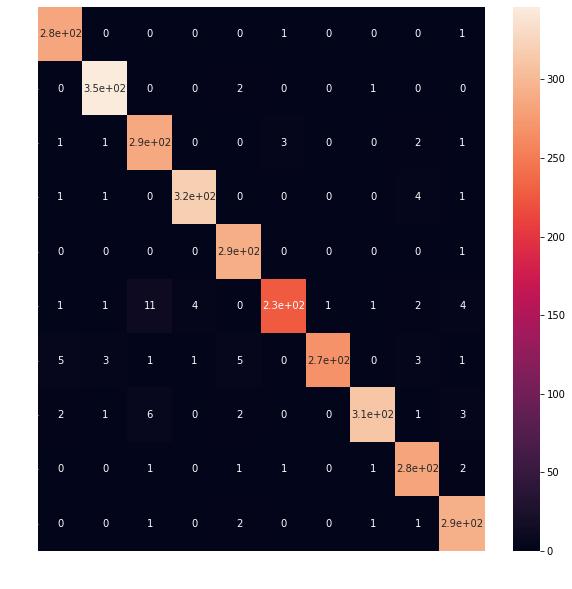

In [ ]:
# Confusion Matrix for the attack model's misclassified images on its own data

cm = confusion_matrix(y_test2, attack_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

## Functional Equivalence Assessment

#### Individual Test Data 
How well did each predict their individual test data

In [ ]:
# Look at first 30 predictions and compare with actual
print(y_pred[:30]) # Victim Model Predictions --> predicted X_test
print(y_test[:30]) # y test data for victim
print()
print(attack_pred[:30]) # Attack Model Predictions --> predicted X_test2
print(y_test2[:30]) # y test data for attack

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 5 3 6 6 7 4]
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4]

[7 7 9 7 9 5 1 9 9 1 6 9 3 1 7 7 6 9 2 5 1 6 2 7 7 3 0 6 6 0]
[7 7 9 7 8 5 1 9 9 1 6 9 3 1 7 7 6 5 2 5 1 6 2 7 1 3 0 6 6 0]


#### Attack Model on Victim Model's Data**
How well can the attack model predict the victim model's data (X_test)<br>

In [ ]:
# get attack model predictions on X_test (victim model test data)
attack_pred2 = np.argmax(stolen_model.predict(X_test), axis=-1) # attack model predictions given same data as original model
print(attack_pred5[:10])

313/313 [==============================] - 109s 348ms/step
[2 0 4 8 7 6 0 6 3 1]


In [ ]:
# Look at first 30 predictions
print(y_pred[:30]) # Victim Model Predictions (unchanged --> uses X_test)
print(attack_pred2[:30]) # Attack Model Predictions --> on X_test
# Compare with actual values
print(y_test[:30]) # Victim Model test data (actual)

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 5 3 6 6 7 4]
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4]
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4]


#### Victim Model on Attack Model's Data
How well does the original model predict on the data from the stolen model (data: X_test2)?

In [ ]:
test_pred = np.argmax(stolen_model.predict(X_test2), axis=-1)
print(test_pred[:10])

94/94 [==============================] - 32s 346ms/step
[7 7 9 7 9 5 1 9 9 1]


In [ ]:
# Look at first 30 predictions
print(test_pred[:30]) # Victim Model Predictions (using X_test2 instead of X_test)
print(attack_pred2[:30]) # Attack Model Predictions (unchanged --> uses X_test2)
print(y_test2[:30]) # y values for X_test2

[7 7 9 7 9 5 1 9 9 1 6 9 3 1 7 7 6 9 2 5 1 6 2 7 7 3 0 6 6 0]
[7 7 9 7 9 5 1 9 9 1 6 9 3 1 7 7 6 9 2 5 1 6 2 7 7 3 0 6 6 0]
[7 7 9 7 8 5 1 9 9 1 6 9 3 1 7 7 6 5 2 5 1 6 2 7 1 3 0 6 6 0]
